In [1]:
import os
from tqdm import tqdm
import zipfile

# path = "/content/data"
path = '/Users/theo/jcursive/data'

# https://github.com/brownvc/decoupled-style-descriptors

if not os.path.exists(path):
  with zipfile.ZipFile("/content/drive/MyDrive/datasets/refined_BRUSH.zip") as zf:
    for member in tqdm(zf.infolist(), desc='Extracting '):
      try:
        zf.extract(member, path)
      except zipfile.error as e:
        pass

In [2]:
import pickle
import pandas as pd

artists = [20, 40, 60]

df = pd.DataFrame()
for artist_id in artists:
  for i in range(160):
    with open(f"{path}/BRUSH/{artist_id}/{i}_resample20", 'rb') as f:
      [sentence, drawing, label] = pickle.load(f)
      row = pd.Series(dtype='float64')
      row['sentence'] = sentence
      row['drawing'] = drawing
      row['label'] = label
      df = pd.concat([df, row], ignore_index=True, axis=1)
df = df.T

# print(df)

In [5]:
import matplotlib.pyplot as plt
import numpy as np

def draw_sentence(idx):
  sentence, drawing, label = df.iloc[idx]
  plt.figure(figsize=(8, 2))
  plt.plot(drawing[:, 0], -drawing[:, 1], c='red', zorder=-1)
  plt.scatter(drawing[:, 0], -drawing[:, 1], c=np.argwhere(label == 1)[:,1], cmap="tab20")
  plt.title(sentence)
  plt.show()

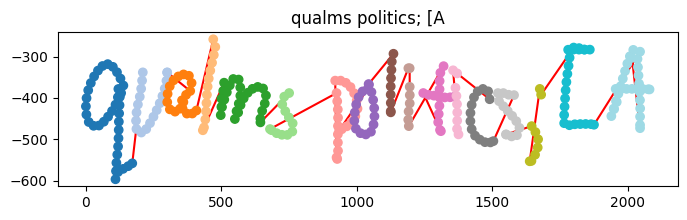

In [6]:
draw_sentence(0)

In [134]:
symbols = []

for _, (sentence, drawing, label) in df.iterrows():
  for i, symbol in enumerate(sentence):
    symbols.extend([(symbol, drawing[label[:, i] == 1]) for i, symbol in enumerate(sentence) if symbol != " "])

symbols_df = pd.DataFrame(symbols, columns=['symbol', 'drawing'])

In [135]:
scaler = 2

def normalize_symbol(drawing):
  # scale X and Y to be between (-1, 1)
  minX, maxX = drawing[:, 0].min(), drawing[:, 0].max()
  minY, maxY = drawing[:, 1].min(), drawing[:, 1].max()

  # Find the maximum range
  rangeX, rangeY = maxX - minX, maxY - minY
  scaleFactor = scaler * 2.0 / max(rangeX, rangeY)

  # Scale the drawing
  drawing[:, 0] = (drawing[:, 0] - minX) * scaleFactor
  drawing[:, 1] = (drawing[:, 1] - minY) * scaleFactor

  # Translate the drawing to center it
  centerX = (drawing[:, 0].max() + drawing[:, 0].min()) / 2
  centerY = (drawing[:, 1].max() + drawing[:, 1].min()) / 2
  drawing[:, 0] -= centerX
  drawing[:, 1] -= centerY

  # Invert Y axis
  drawing[:, 1] = -drawing[:, 1]

  # normalize points that are out of bounds
  oob = np.argwhere(np.sqrt(drawing[:, 0] ** 2 + drawing[:, 1] ** 2) > 1)
  letter_transformed = np.copy(drawing[:, :2]) # remove the third column (stroke start/stop)
  letter_transformed[oob, 0] = drawing[oob, 0] / np.sqrt(drawing[oob, 0] ** 2 + drawing[oob, 1] ** 2)
  letter_transformed[oob, 1] = drawing[oob, 1] / np.sqrt(drawing[oob, 0] ** 2 + drawing[oob, 1] ** 2)
  return letter_transformed

symbols_df['drawing'] = symbols_df['drawing'].apply(normalize_symbol)

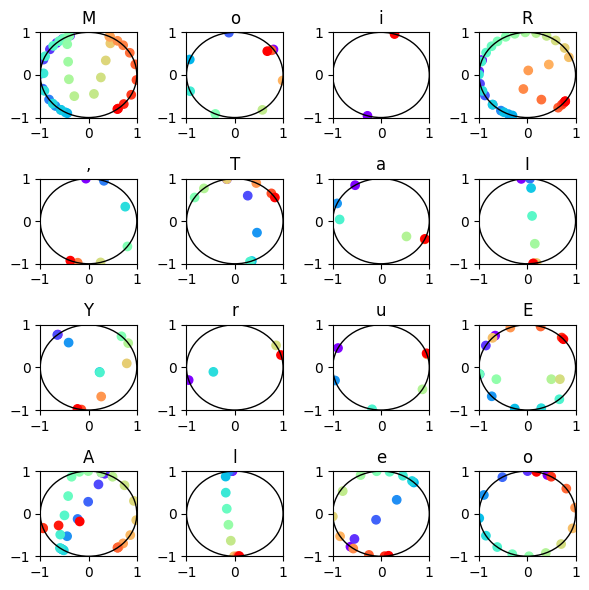

In [136]:
fig = plt.figure(figsize=(6, 6))
for i, row in enumerate(symbols_df.sample(16).iloc):
  ax = fig.add_subplot(4, 4, i + 1)
  sym = row['symbol']
  draw = row['drawing']

  ax.set_xlim(-1, 1)
  ax.set_ylim(-1, 1)
  ax.set_title(sym)
  ax.scatter(draw[:, 0], draw[:, 1], cmap="rainbow", c=np.arange(len(draw)))
  ax.add_patch(plt.Circle((0, 0), 1, fill=False))
plt.tight_layout()
plt.show()

In [137]:
alphabet_df = symbols_df[symbols_df['symbol'].str.isupper()]

In [138]:
alphabet_df['symbol'].value_counts()

symbol
A    1811
E    1491
O    1446
S    1361
I    1332
R    1278
T    1239
N    1179
C    1113
L     959
M     958
P     871
H     774
D     764
F     721
G     674
W     616
B     591
U     452
J     432
Y     406
K     396
V     378
X     285
Q     198
Z     188
Name: count, dtype: int64

In [139]:
!pip install tslearn

Defaulting to user installation because normal site-packages is not writeable


Score:0.93


<Figure size 640x480 with 0 Axes>

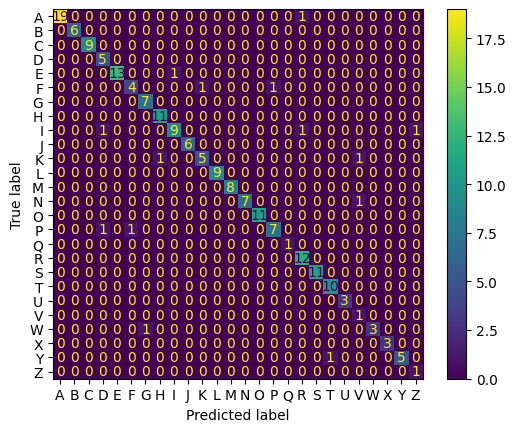

In [140]:
from tslearn.neighbors import KNeighborsTimeSeriesClassifier
from tslearn.utils import to_time_series_dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score

# abdf = pd.concat([alphabet_df[alphabet_df['symbol'] == 'A'], alphabet_df[alphabet_df['symbol'] == 'B']])

sdf = alphabet_df.sample(1000)

X = sdf['drawing'].to_numpy()
onehot = pd.get_dummies(sdf['symbol'])
y = np.argmax(onehot.to_numpy(), axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

X_train = to_time_series_dataset(X_train)
X_test = to_time_series_dataset(X_test)

knn = KNeighborsTimeSeriesClassifier(n_neighbors=5)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)

cf = confusion_matrix(y_test, y_pred, labels=knn.classes_)
score = accuracy_score(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cf, display_labels=[chr(x + ord('A')) for x in knn.classes_])
plt.tight_layout()
print("Score:" + str(score))
disp.plot()


In [142]:
import pygame, threading

input = []

# Initialize Pygame
pygame.init()

# Initialize the joystick module
pygame.joystick.init()

# Check if there is at least one joystick connected
if pygame.joystick.get_count() > 0:
    # Create a Joystick object for the first joystick
    joystick = pygame.joystick.Joystick(0)
    joystick.init()

    # Game loop
    running = True
    recording = False

    while running:
        for event in pygame.event.get():
            if event.type == pygame.QUIT:
                running = False

            if event.type == pygame.JOYBUTTONDOWN:
                if recording == True:
                    recording = False
                    input_np = np.array(input)
                    pred = knn.predict([input_np])
                    print(chr(pred[0] + ord('A')))
                    input = []
                else:
                    recording = True
                    print(">", end="")

        if recording:
            # Get the value of axis 0
            x = -joystick.get_axis(1)
            y = -joystick.get_axis(0)
            input.append([x, y])

            # Delay to make the output readable
            pygame.time.delay(20)
else:
    print("No joystick found")

# Quit Pygame
pygame.quit()

# print("recording size:", len(input))
# plt.xlim(-1, 1)
# plt.ylim(-1, 1)
# plt.scatter(input_np[:, 0], input_np[:, 1], cmap="rainbow", c=np.arange(len(input_np)))
# plt.colorbar()


>A
>B
>C
>D
>E
>S
>S
>E
>F
>E
>J
>R
>G
>D
>D
>M


KeyboardInterrupt: 

: 